# F20DL Lab 10

## Setup 

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import pandas as pd
import math
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=10)
mpl.rc('xtick', labelsize=10)
mpl.rc('ytick', labelsize=10)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Ignore convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

In [2]:
# Load the dataset into numpy arrays
images = np.load("./datasets/smiley_X.npy")
labels = np.load("./datasets/smiley_Y.npy")

In [3]:
# Flatten image data and convert values to int
X = np.asarray([x.flatten() for x in images]).astype(int)
y = labels.astype(int)

In [4]:
# data is a list of all images. Images are represented as a flattened row of pixel values.
# To get pixel (r, c) of image i, use X[i-1][9*(r-1) + (c-1)] 
# Or use images[i][r-1][c-1][0]

# X[0] returns a row of pixel values representing the 1st image.
# X[0][24] and images[0][2][6][0] return the value of the pixel in the 3rd row and 7th column of the 1st image 
# (r=3, c=7).
# y[0] returns the label for the 1st image.
images[0][0][0][0]

0.0

In [5]:
# Shows smiley as an image. 'smiley' should be an element in 'images'
def show_smiley(smiley):
    plt.figure(figsize=(2,2))
    plt.imshow(smiley, cmap="Greys")

In [6]:
# Shifts a percentage of instances from the training set to the test set and returns the new training and test sets
def shift_instances(d_train, d_test, t_train, t_test, percent):    
    shift_count = math.ceil(percent * d_train.shape[0])    # No. of instances to shift

    # Shift first x% of samples to test set
    new_d_train = d_train[shift_count:]
    new_d_test = np.concatenate((d_test, d_train[:shift_count]))
    new_t_train = t_train[shift_count:]
    new_t_test = np.concatenate((t_test, t_train[:shift_count]))
    return (new_d_train, new_d_test, new_t_train, new_t_test)

In [7]:
# Displays confusion matrix and prints common evaluation metrics
def show_metrics(clf, y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    
    acc = round(accuracy_score(y_test, y_pred), 3)
    tn, fp, fn, tp = cm.ravel()
    tpr = round(tp/(tp+fn), 3)
    fpr = round(fp/(fp+tn), 3)
    precision = round(tp/(tp+fp), 3)
    recall = round(tp/(tp+fn), 3)
    f_measure = (2 * recall * precision) / (recall + precision)
    f_measure = round(f_measure, 3)
    
    text = f'''
    Metrics for Class 1:
    Accuracy =   {acc}
    TP rate =    {tpr}
    FP rate =    {fpr}
    Precision =  {precision}
    Recall =     {recall}
    F measure =  {f_measure}
    '''
    
    fig, axes = plt.subplots(figsize=(4,4))
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_).plot(ax=axes)
    plt.show()
    
    print(text)
    
    return [acc, tpr, fpr, precision, recall, f_measure]

In [8]:
def plot_param_tune(param_vals, param_scores, xlabel, ylabel="Accuracy", line_style="-"):
    plt.plot(param_vals, param_scores, line_style)
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

## Multilayer Perceptron

### MLP 0

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=1) # 10% training and 90% test
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 14, Testing samples: 130


In [10]:
# Create MLP object
classifier = MLPClassifier(random_state=1)

# Train MLP Classifer
classifier = classifier.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = classifier.predict(X_train)

In [11]:
t0_acc = accuracy_score(y_train, y_pred)

In [12]:
cross_val_score(classifier, X_train, y_train, cv=6)

array([1., 1., 1., 1., 1., 1.])

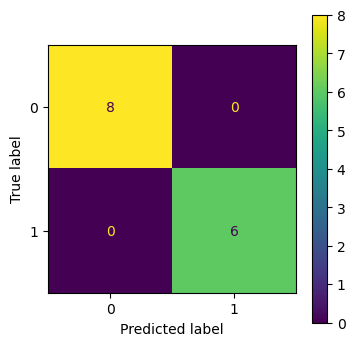


    Metrics for Class 1:
    Accuracy =   1.0
    TP rate =    1.0
    FP rate =    0.0
    Precision =  1.0
    Recall =     1.0
    F measure =  1.0
    


In [13]:
metrics0 = show_metrics(classifier, y_train, y_pred)

## Hyperparameter Tuning

### No. of Layers

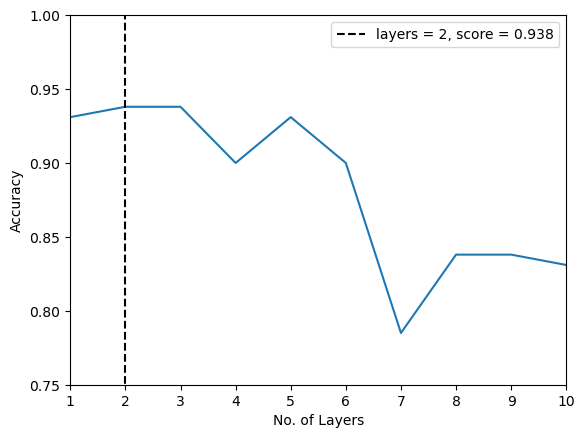

In [14]:
layers = list(range(1, 21))
layer_scores = []

# iterate through differ
for layer_count in layers:
    
    layer_sizes = tuple([100] * layer_count)

    # train the model with specified number of layers
    mlp = MLPClassifier(hidden_layer_sizes = layer_sizes, random_state = 0)
    mlp.fit(X_train, y_train)
        
    # predict and score the model
    y_pred = mlp.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    layer_scores.append(acc)

best_score = np.max(layer_scores)
plot_param_tune(layers, layer_scores, "No. of Layers")
plt.axis([1, 10, 0.75, 1])
plt.plot([2, 2], [-100, 100], "k--", label=f"layers = 2, score = {best_score}")
plt.legend()
plt.show()

### No. of Neurons

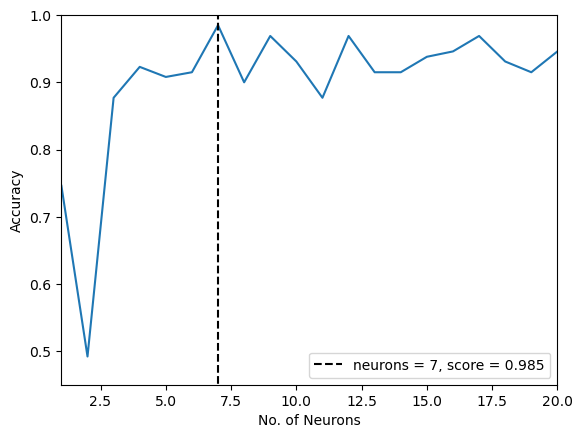

In [15]:
layer_sizes = list(range(1, 21))
neuron_scores = []

# iterate through different layer sizes
for layer_size in layer_sizes:

    # train the model with specified layer size
    mlp = MLPClassifier(hidden_layer_sizes = (layer_size,), random_state = 1)
    mlp.fit(X_train, y_train)
        
    # predict and score the model
    y_pred = mlp.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    neuron_scores.append(acc)

best_score = np.max(neuron_scores)
plot_param_tune(layer_sizes, neuron_scores, "No. of Neurons")
plt.axis([1, 20, 0.45, 1])
plt.plot([7, 7], [-100, 100], "k--", label=f"neurons = 7, score = {best_score}")
plt.legend()
plt.show()

### No. of Iterations

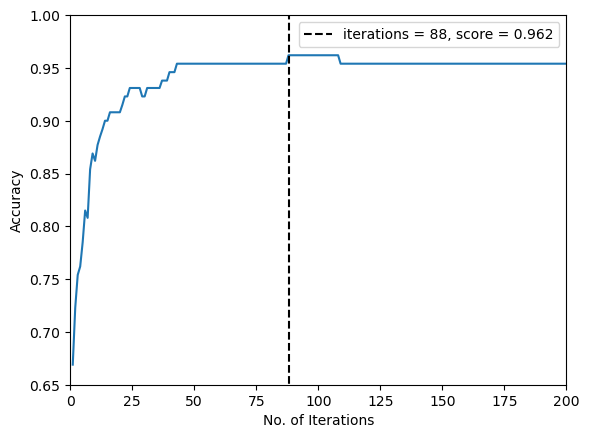

In [16]:
iterations = list(range(1, 201))    # 1 step in range [1, 200]
iter_scores = []

for iter in iterations:
    clf = MLPClassifier(max_iter=iter, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    iter_scores.append(acc)

best_score = np.max(iter_scores)
plot_param_tune(iterations, iter_scores, "No. of Iterations")
plt.axis([0, 200, 0.65, 1])
plt.plot([88, 88], [-100, 100], "k--", label=f"iterations = 88, score = {best_score}")
plt.legend()
plt.show()

### Momentum

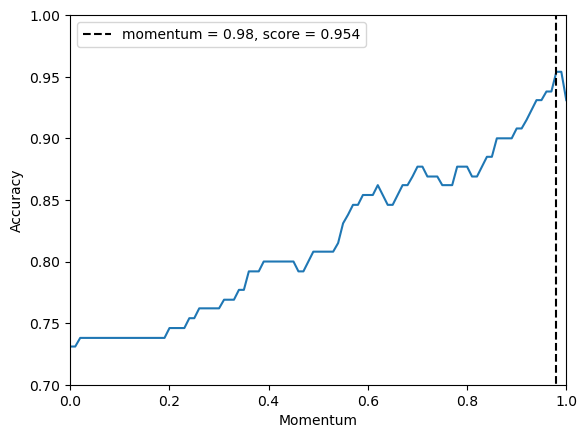

In [17]:
momentum = [0.01*x for x in range(101)]    # 0.01 steps in range [0, 1]
mmnt_scores = []

for mmnt in momentum:
    clf = MLPClassifier(momentum=mmnt, solver="sgd", random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    mmnt_scores.append(acc)

best_score = np.max(mmnt_scores)
plot_param_tune(momentum, mmnt_scores, "Momentum")
plt.axis([0, 1, 0.70, 1])
plt.plot([0.98, 0.98], [-100, 100], "k--", label=f"momentum = 0.98, score = {best_score}")
plt.legend()
plt.show()

### Validation Threshold

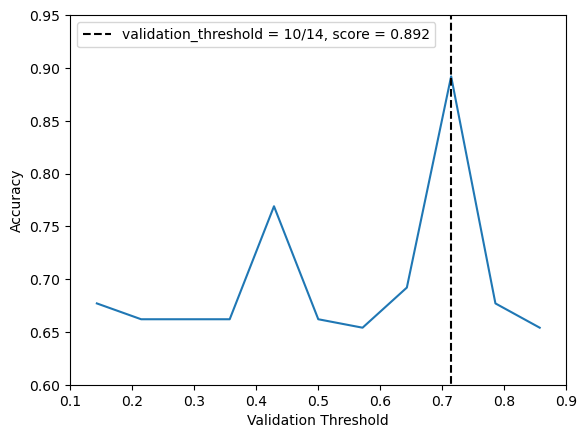

In [18]:
x_count = X_train.shape[0]
val_thresholds = [x/x_count for x in range(2, x_count-1)]    # 0.01 steps in range [0.01, 0.99]
val_t_scores = []

for val_t in val_thresholds:
    clf = MLPClassifier(validation_fraction=val_t, early_stopping=True, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    val_t_scores.append(acc)

best_score = np.max(val_t_scores)
plot_param_tune(val_thresholds, val_t_scores, "Validation Threshold")
plt.axis([0.1, 0.9, 0.6, 0.95])
plt.plot([10/14, 10/14], [-100, 100], "k--", label=f"validation_threshold = 10/14, score = {best_score}")
plt.legend()
plt.show()

### Learning Rate

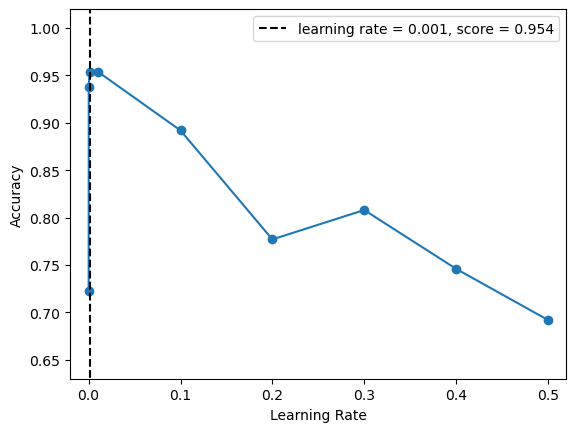

In [19]:
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]
lr_scores = []

for lr in learning_rates:
    clf = MLPClassifier(learning_rate_init=lr, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    lr_scores.append(acc)

best_score = np.max(lr_scores)
plot_param_tune(learning_rates, lr_scores, "Learning Rate", line_style="o-")
plt.axis([-0.02, 0.52, 0.63, 1.02])
plt.plot([0.001, 0.001], [-100, 100], "k--", label=f"learning rate = 0.001, score = {best_score}")
plt.legend()
plt.show()

### Batch Size

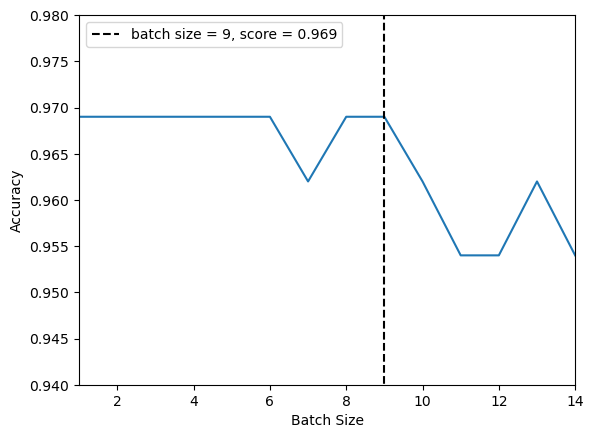

In [20]:
batch_sizes = list(range(1, X_train.shape[0]+1))    # 1 step in range [1, train_size]
batch_scores = []

for bs in batch_sizes:
    clf = MLPClassifier(batch_size=bs, random_state=1)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = round(accuracy_score(y_test, y_pred), 3)
    batch_scores.append(acc)

best_score = np.max(batch_scores)
plot_param_tune(batch_sizes, batch_scores, "Batch Size")
plt.axis([1, 14, 0.94, 0.98])
plt.plot([9, 9], [-100, 100], "k--", label=f"batch size = 9, score = {best_score}")
plt.legend()
plt.show()

## Tuned Multilayer Perceptrons

In [21]:
opt_lr = 0.001
opt_iter = 88
opt_mmnt = 0.98
opt_val_t = 10/14
opt_batch = 9
opt_neuron = 7
opt_layers = 2

### MLP 1

In [22]:
print("Training samples: %i, Testing samples: %i" % (X_train.shape[0], X_test.shape[0]))

Training samples: 14, Testing samples: 130


In [23]:
# Create MLP object
classifier1 = MLPClassifier(random_state=1, 
                            max_iter=opt_iter, 
                            learning_rate_init=opt_lr, 
                            hidden_layer_sizes=(opt_neuron, opt_neuron))

# Train MLP Classifer
classifier1 = classifier1.fit(X_train,y_train)

#Predict the response for test dataset
y1_pred = classifier1.predict(X_test)

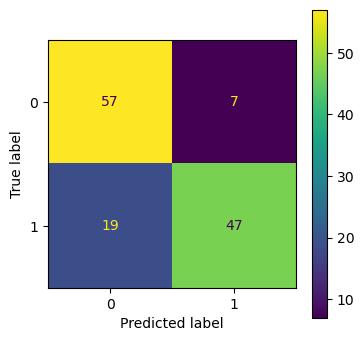


    Metrics for Class 1:
    Accuracy =   0.8
    TP rate =    0.712
    FP rate =    0.109
    Precision =  0.87
    Recall =     0.712
    F measure =  0.783
    


In [24]:
mlp1_acc = accuracy_score(y_test, y1_pred)
metrics1 = show_metrics(classifier1, y_test, y1_pred)

### MLP 2

In [25]:
# Shift 30% of original training data to test set
X2_train, X2_test, y2_train, y2_test = shift_instances(X_train, X_test, y_train, y_test, 0.3)
print("Training samples: %i, Testing samples: %i" % (X2_train.shape[0], X2_test.shape[0]))

Training samples: 9, Testing samples: 135


In [26]:
# Create MLP object
classifier2 = MLPClassifier(random_state=1, 
                            max_iter=opt_iter, 
                            learning_rate_init=opt_lr, 
                            hidden_layer_sizes=(opt_neuron, opt_neuron))

# Train MLP Classifer
classifier2 = classifier2.fit(X2_train,y2_train)

#Predict the response for test dataset
y2_pred = classifier2.predict(X2_test)

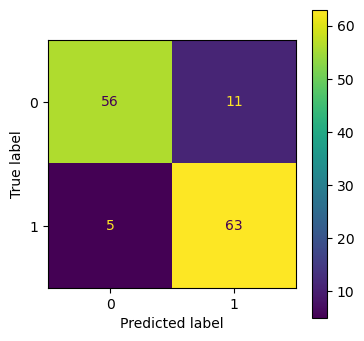


    Metrics for Class 1:
    Accuracy =   0.881
    TP rate =    0.926
    FP rate =    0.164
    Precision =  0.851
    Recall =     0.926
    F measure =  0.887
    


In [27]:
mlp2_acc = accuracy_score(y2_test, y2_pred)
metrics2 = show_metrics(classifier2, y2_test, y2_pred)

### MLP 3

In [28]:
# Shift 60% of original training data to test set
X3_train, X3_test, y3_train, y3_test = shift_instances(X_train, X_test, y_train, y_test, 0.6)
print("Training samples: %i, Testing samples: %i" % (X3_train.shape[0], X3_test.shape[0]))

Training samples: 5, Testing samples: 139


In [29]:
# Create MLP object
classifier3 = MLPClassifier(random_state=1, 
                            max_iter=opt_iter, 
                            learning_rate_init=opt_lr, 
                            hidden_layer_sizes=(opt_neuron, opt_neuron))

# Train MLP Classifer
classifier3 = classifier3.fit(X3_train,y3_train)

#Predict the response for test dataset
y3_pred = classifier3.predict(X3_test)

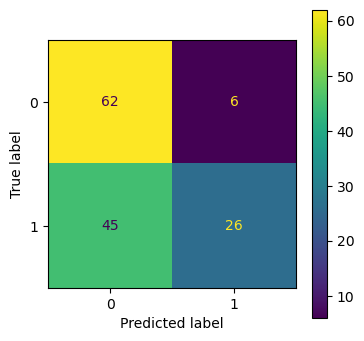


    Metrics for Class 1:
    Accuracy =   0.633
    TP rate =    0.366
    FP rate =    0.088
    Precision =  0.812
    Recall =     0.366
    F measure =  0.505
    


In [30]:
mlp3_acc = accuracy_score(y3_test, y3_pred)
metrics3 = show_metrics(classifier3, y3_test, y3_pred)